# Anomaly Detection in Railway substations

In this project we evaluate the perfomance of a deep learning autoencoder as part of an anomaly detection system to be deployed in operational line substations of tram railways. 

In [304]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy import stats

import math

In [404]:
def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

In [51]:
def half_masked_corr_heatmap(df, title=None, file=None):
    plt.figure(figsize=(15,15))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm')
    
    if title: plt.title(f"\n{title}\n", fontsize=18)
    plt.xlabel('')
    plt.ylabel('')
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
        
    return

In [52]:
def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(4,10))
    sns.set(font_scale=1.5)
    
    sns.heatmap(dataframe.corr()[[target]].sort_values(target,
                                                ascending=False)[1:],
                annot=True,
                cmap='coolwarm')
    
    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

In [53]:
def gen_scatterplots(dataframe, target_column, list_of_columns, cols=1, file=None):
    rows      = int(np.ceil(len(list_of_columns)/cols))
    figwidth  = 5 * cols
    figheight = 5 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(list_of_columns):
        ax[i].scatter(dataframe[column],
                      dataframe[target_column],
                      color=color_choices[i % len(color_choices)],
                      alpha = 0.1)

#           Individual subplot titles, optional
#             ax[i].set_title(f'{column} vs. {target_column}', fontsize=18)

        ax[i].set_ylabel(f'{target_column}', fontsize=14)
        ax[i].set_xlabel(f'{column}', fontsize=14)

    fig.suptitle('\nEach Feature vs. Target Scatter Plots', size=16)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    return

In [151]:
def gen_histograms(dataframe, cols=1, file=None):
    rows      = math.ceil(len(dataframe.columns)/cols)
    figwidth  = 5 * cols
    figheight = 5 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(dataframe.columns):
        ax[i].hist(dataframe[column],
                      color=color_choices[i % len(color_choices)],
                      alpha = 1)
        
        ax[i].set_title(f'{dataframe[column].name}', fontsize=18)
        ax[i].set_ylabel('Observations', fontsize=14)
        ax[i].set_xlabel('', fontsize=14)
        
    fig.suptitle('\nHistograms for All Variables in Dataframe', size=15)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();

    return

In [350]:
normal_data = pd.read_csv("../data/railways/normal.csv", delimiter='\t')

In [351]:
normal_data.drop(["Unnamed: 27", 'time [s]', 'line [1]', 'track/ direction [1]'], axis=1, inplace=True)
normal_data.drop(list(normal_data.filter(regex='target')), axis=1, inplace=True)
normal_data.head()

,loc. (actual) [km],way (actual) [km],speed (actual) [km/h],voltage [V],current [A],track-earth voltage [V],energy input [kWh],energy balance [kWh],usable braking energy [kWh],used braking energy [kWh],recuperated braking energy [kWh],energy braking resistor [kWh],state [1],tractive effort (actual) [kN],line and running resistance [kN],acceleration (actual) [m/(s*s)],desired speed [km/h],train configuration [1],utilization rate [%]
0,9.340000,0.000000,0.2,785.202087,34.513409,-1.398076,0.015056,0.015056,0.0,0.0,0.0,0.0,15.0,0.000000,0.000000,0.000000,0.0,2.0,100.0
1,9.339889,0.000111,0.2,785.416748,35.818111,-2.094278,0.030685,0.030685,0.0,0.0,0.0,0.0,30.0,1.167702,1.167702,0.000000,0.2,2.0,100.0
2,9.339778,0.000222,0.2,784.113892,35.877624,-2.175555,0.046314,0.046314,0.0,0.0,0.0,0.0,30.0,1.167702,1.167702,0.000000,0.2,2.0,100.0
3,9.338555,0.001444,4.2,778.748291,96.419258,-1.403793,0.088028,0.088028,0.0,0.0,0.0,0.0,20.0,33.361591,1.167702,0.555556,4.2,2.0,100.0
4,9.334444,0.005556,10.6,773.262268,231.095718,-0.477682,0.187305,0.187305,0.0,0.0,0.0,0.0,20.0,52.718021,1.207798,0.888889,10.6,2.0,100.0


## Exploratory Analysis

### Feature Selection

We need to select the features that we are going to use. We are not able to use all features in the danger of overfitting our dataset due to its relative small size. To select our features we we look at the correlation matrix of our dataframe.

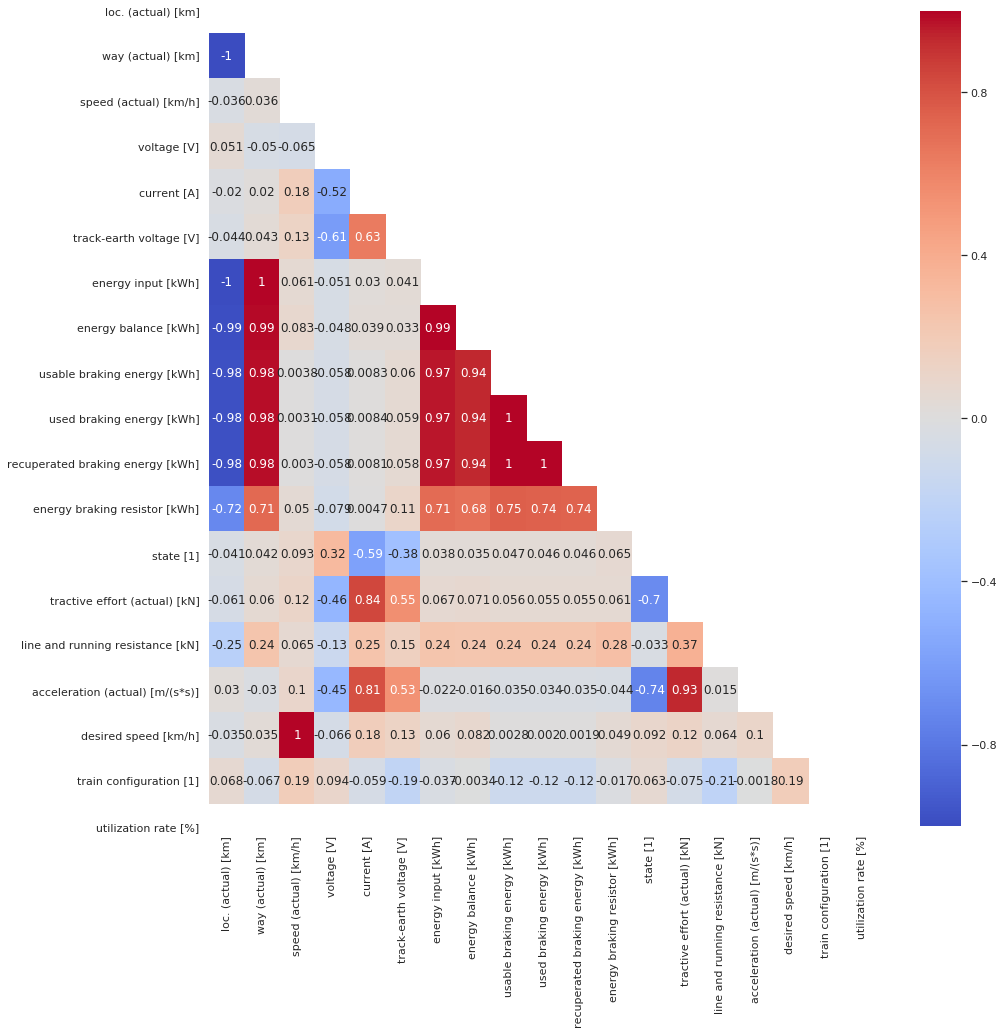

In [352]:
half_masked_corr_heatmap(normal_data)

So we are going to drop the features that are strongly correlated since they are not going to give our model any useful information.

In [397]:
# selected features
features = ['way (actual) [km]',
            'speed (actual) [km/h]',
            'voltage [V]',
            'track-earth voltage [V]',
            'energy input [kWh]',
            'energy balance [kWh]',
            'usable braking energy [kWh]',
            'used braking energy [kWh]',
            'state [1]',
            'acceleration (actual) [m/(s*s)]',
            'tractive effort (actual) [kN]',
            'line and running resistance [kN]',
            'train configuration [1]'
            ]
nb_features = len(features)
normal_data = normal_data[features]

######  Dataset Standarization

Here we are going to standarize our dataset, meaning we will make all features to have mean of 0 and variance of 1.

In [398]:
scaler  = StandardScaler()
scaled = scaler.fit_transform(normal_data.values)
normal_data.iloc[:,:] = scaled


In [399]:
normal_data.head()

,way (actual) [km],speed (actual) [km/h],voltage [V],track-earth voltage [V],energy input [kWh],energy balance [kWh],usable braking energy [kWh],used braking energy [kWh],state [1],acceleration (actual) [m/(s*s)],tractive effort (actual) [kN],line and running resistance [kN],train configuration [1]
0,-1.740432,-1.213179,-0.017507,-0.736782,-1.718599,-1.624484,-1.946821,-1.918963,-1.445523,0.002899,-0.024253,-0.071408,0.61966
1,-1.740390,-1.213179,-0.006938,-1.044861,-1.717420,-1.622865,-1.946821,-1.918963,-0.326480,0.002899,0.021873,0.058079,0.61966
2,-1.740349,-1.213179,-0.071086,-1.080827,-1.716241,-1.621246,-1.946821,-1.918963,-0.326480,0.002899,0.021873,0.058079,0.61966
3,-1.739892,-0.924648,-0.335270,-0.739312,-1.713094,-1.616925,-1.946821,-1.918963,-1.072509,1.364921,1.293579,0.058079,0.61966
4,-1.738357,-0.463000,-0.605383,-0.329494,-1.705605,-1.606640,-1.946821,-1.918963,-1.072509,2.182135,2.058187,0.062525,0.61966


### Dataset Visualisation

First we present some statistical information about our dataset.

In [400]:
normal_data.describe()

,way (actual) [km],speed (actual) [km/h],voltage [V],track-earth voltage [V],energy input [kWh],energy balance [kWh],usable braking energy [kWh],used braking energy [kWh],state [1],acceleration (actual) [m/(s*s)],tractive effort (actual) [kN],line and running resistance [kN],train configuration [1]
count,1002.000000,1.002000e+03,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1002.000000,1.002000e+03
mean,0.000000,-2.481936e-17,0.000000,0.000000,0.000000,0.000000,0.000000,-5.672996e-17,6.470761e-17,1.506890e-17,7.091245e-18,0.000000,7.091245e-17
std,1.000499,1.000499e+00,1.000499,1.000499,1.000499,1.000499,1.000499,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499,1.000499e+00
min,-1.740432,-1.220392e+00,-2.923280,-7.255551,-1.718599,-1.624484,-1.946821,-1.918963e+00,-1.445523e+00,-3.572408e+00,-2.780664e+00,-3.401675,-1.613789e+00
25%,-0.864004,-1.213179e+00,-0.385375,-0.446894,-0.809624,-0.776582,-0.830946,-8.416503e-01,-1.072509e+00,-5.078587e-01,-7.059458e-01,-0.505879,-1.613789e+00
50%,0.018386,-2.515482e-02,-0.113643,0.004866,-0.058947,-0.156692,0.194431,1.963910e-01,-3.264804e-01,2.899461e-03,4.024423e-02,0.310217,6.196595e-01
75%,0.773398,7.344016e-01,0.137941,0.440409,0.830241,0.960399,0.572176,5.659989e-01,1.165576e+00,3.008417e-01,3.947521e-01,0.646084,6.196595e-01
max,1.798409,2.559356e+00,5.634746,5.129091,1.804036,1.841856,1.808544,1.815679e+00,1.165576e+00,2.944867e+00,2.900344e+00,3.317644,6.196595e-01


Also we plot the boxplots of our features. We can see that both voltage and track_earth voltage have outliers. 

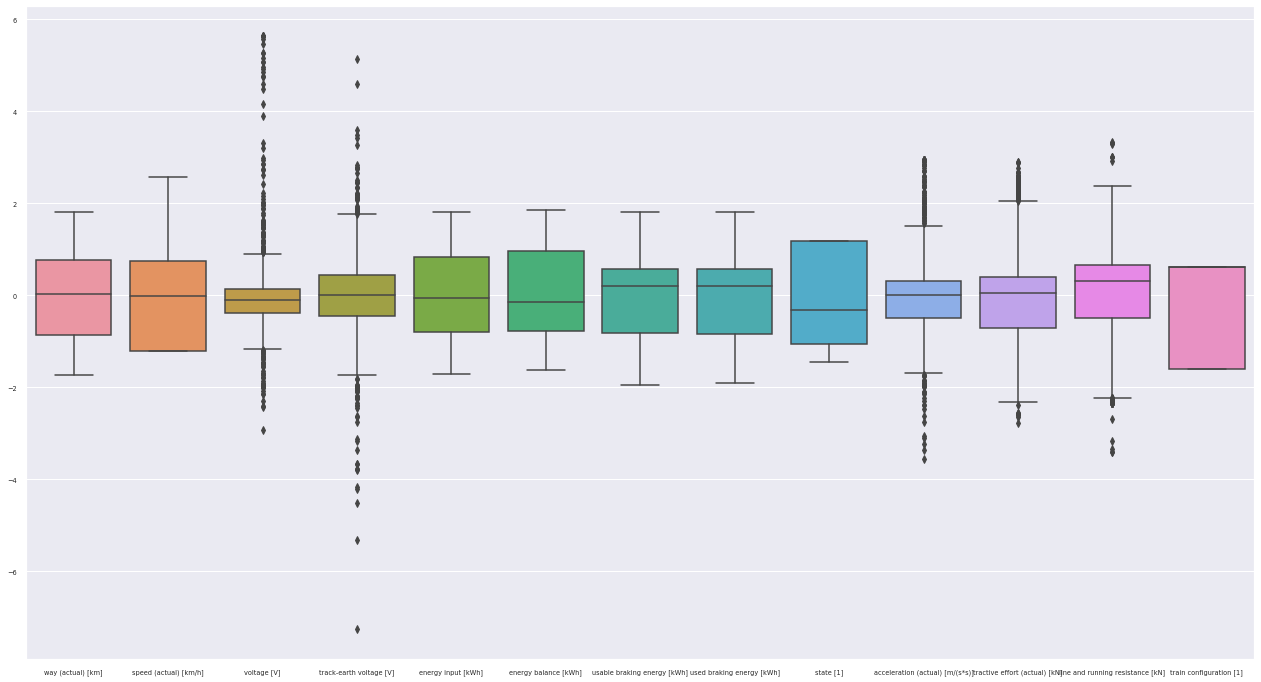

In [401]:
plt.figure(figsize=(22,12))
sns.set(font_scale=0.6)

sns.boxplot(data=normal_data)

The feature of interest in this study is voltage. So we plot the correlation of voltage we the other features.

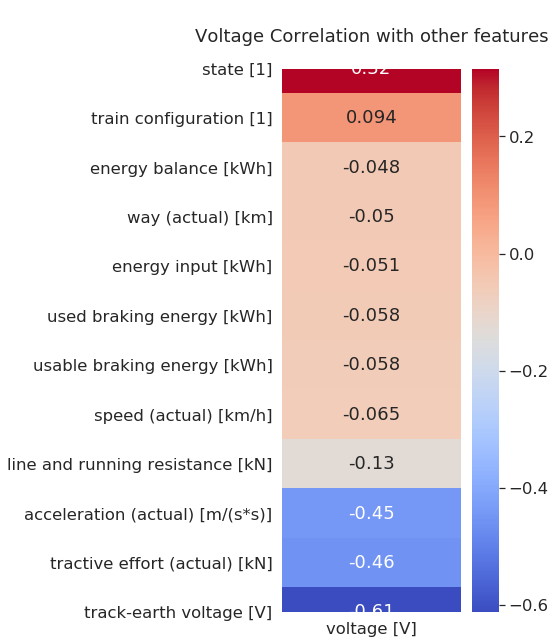

In [402]:
corr_to_target(normal_data, 'voltage [V]', 'Voltage Correlation with other features')

We observe that voltage is strongly correlated with acceleration, state and track earth voltage. 

Now we make scatter plots of each feature against our target feature to observe the relationships between them,  sa well as histograms to observe the distributions of our features.

We are going to drop the outliers to make a more robust dataset.

In [405]:
drop_numerical_outliers(normal_data)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions
  after removing the cwd from sys.path.


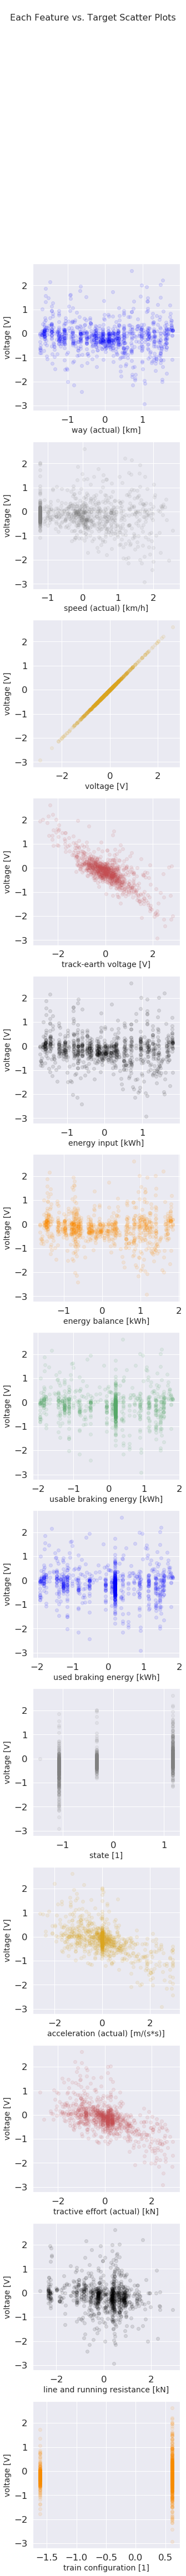

In [407]:
gen_scatterplots(normal_data, 'voltage [V]', features)

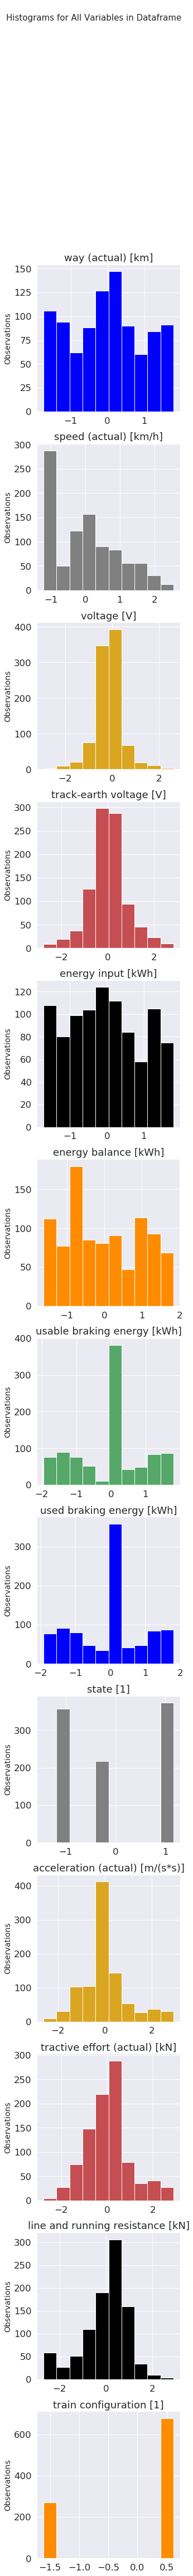

In [409]:
gen_histograms(normal_data)

## Building our Model

The model we chose to reconstruct our data is a deep autoencoder.
Autoencoders encodes the input values x using a function f. Then decodes the encoded values f(x) using a function g to create output values identical to the input values.

Deep Autoencoders consist of two identical deep networks. One network for encoding and another for decoding. Typically deep autoencoders have 4 to 5 layers for encoding and the next 4 to 5 layers for decoding.

We are going to build a deep Autoencoder with pytorch so we should import the following libraries

In [203]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

We are going to implement our dataset by inheriting from pytorch Dataset. This allows as to use the native pytorch dataloader easily, to optimize our memory usage. The class we implemented includes every preprocessing step we presented earlier.

In [415]:
class TimeSeriesDataSet(Dataset):

    def __init__(self, datafile, features, feature_to_reconstruct):
        self.features = features
        self.feature_to_reconstruct = feature_to_reconstruct

        df = pd.read_csv(datafile, usecols=self.features, delimiter='\t').dropna()
        constrains = df.select_dtypes(include=[np.number]) \
            .apply(lambda x: np.abs(stats.zscore(x)) < 3) \
            .all(axis=1)
        # Drop (inplace) values set to be rejected
        df.drop(df.index[~constrains], inplace=True)
        
        #Standarize the dataset
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df)
        df.iloc[:, :] = scaled
        self.dataframe = df
        self.dataset = torch.Tensor(scaled)
        self.features = df.columns
        
    def feature_count(self):
        return len(self.dataframe.columns)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return torch.Tensor(self.dataset[item])
    
    def get_feature(self, feature):
        return self.dataframe[f'{feature}']

Then we are going to implement our Autoencoder using the pytorch Neural Network Module.

In [416]:
class Encoder(nn.Module):
    """This is the encoder part of the autoencoder"""
    def __init__(self, num_features):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(num_features, 512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16,4)

        self.activation = nn.ReLU()
 

    
    def forward(self, x):
        x = self.activation(self.fc0(x))
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)

        return x
        

In [417]:
class Decoder(nn.Module):
    def __init__(self, num_features):
        """The decoder part of the autoencoder """
        
        super().__init__()
        
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, num_features)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.fc6(x)
        return x

In [418]:
class Autoencoder(nn.Module):
    def __init__(self, nb_features):
        super().__init__()
        self.encoder = Encoder(nb_features)
        self.decoder = Decoder(nb_features)
    def forward(self, x):
        code = self.encoder(x)
        self.code = code
        reconstructed = self.decoder(code)
        return reconstructed, code

We are going to train our autoencoder on our training dataset. We want to achieve the lowest possible reconstruction error with a relative small encoding dimension to improve the generalization ability of our Autoencoder. For our purposes we ideally want our autoencoder to learn to represent and reconstruct the normal multidimensional signal, in such way that given an abnormal sample he will be unable to reconstruct it. The difference between the reconstructed and the true signal is called the reconstruction error of the Autoencoder. In that regard points with large reconstruction error are called __anomalies__.

In [419]:
def l1_error(true, predicted):
    return np.abs(true - predicted)

We are going to use __l1_error__ as the reconstruction error.

In [420]:
# we make it so we are going o run our network with the right device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = TimeSeriesDataSet(f"../data/railways/normal.csv",
                            features=features,
                            feature_to_reconstruct='voltage [V]')
abnormal_1 = TimeSeriesDataSet(f"../data/railways/error1.csv",
                            features=features,
                            feature_to_reconstruct='voltage [V]')

abnormal_2 = TimeSeriesDataSet(f"../data/railways/error2.csv",
                            features=features,
                            feature_to_reconstruct='voltage [V]')

abnormal_3 = TimeSeriesDataSet(f"../data/railways/error3.csv",
                            features=features,
                            feature_to_reconstruct='voltage [V]')

"""We split our dataset in 80/20 fashion"""
batch_size = 128
workers = 4
train_len = int(0.8*len(dataset))
test_len = len(dataset) - train_len
train, validation = random_split(dataset, [train_len, test_len])
features = dataset.features
nb_features = dataset.feature_count()



"""We initiate our dataloaders"""
train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=workers, shuffle=True)
validation_dataloader = DataLoader(validation, batch_size=batch_size, num_workers=workers, shuffle=True)

ae = Autoencoder(nb_features).to(device)
"""We chose the popular Adam optimizer """
optimizer = optim.Adam(ae.parameters())

"""we initialize two lists to keep out validation and training loss history"""
history_train_loss = []
history_val_loss = []
dataloaders = {'train': train_dataloader,
              'validation': validation_dataloader}

In [421]:
"""Our training loop"""
for epoch in tqdm(range(400)):
    for mode, dataloader in dataloaders.items():
        for batch in dataloader:
                if mode == 'train':
                    ae.train()
                    optimizer.zero_grad()
                    reconstructed, code = ae(batch)
                    train_loss = F.l1_loss(batch, reconstructed)
                    train_loss.backward()
                    optimizer.step()

                else:
                    if epoch%4==0:
                        ae.eval()
                        reconstructed, code = ae(batch)
                        val_loss = F.mse_loss(batch, reconstructed)*4
                        

    if epoch%4 == 0:
        history_train_loss.append(train_loss.item())
        history_val_loss.append(val_loss.item())
        #print(f"Epoch: {epoch+1}, Train_Loss: {train_loss.item()}, Validation Loss: {val_loss}")
            

100%|██████████| 400/400 [02:13<00:00,  3.24it/s]


<Figure size 720x576 with 0 Axes>

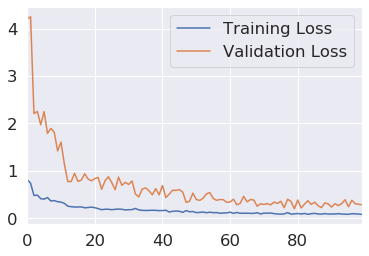

In [422]:
history = pd.DataFrame({"Training Loss": history_train_loss,
                        "Validation Loss": history_val_loss})
plt.figure(figsize=(10,8))
history.plot()


So we reach a fairly low reconstruction error. Lets use our trained __Autoencoder__ to reconstruct part fo our normal signal and evaluate its perfomance.

In [423]:
reconstructed_signal = ae(dataset[:])[0].detach().numpy()
signal = dataset[:].detach().numpy()

<module 'matplotlib.pyplot' from '/usr/lib/python3.7/site-packages/matplotlib/pyplot.py'>

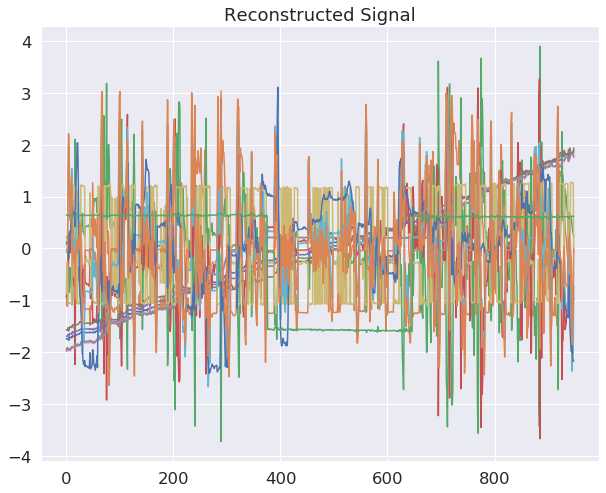

In [424]:
plt.figure(figsize=(10,8))
plt.title("Reconstructed Signal")
plt.plot(reconstructed_signal)
plt

<module 'matplotlib.pyplot' from '/usr/lib/python3.7/site-packages/matplotlib/pyplot.py'>

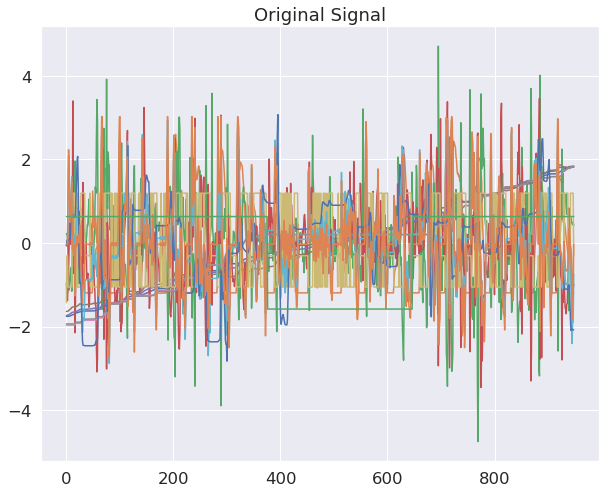

In [425]:
plt.figure(figsize=(10,8))
plt.title("Original Signal")
plt.plot(signal)
plt

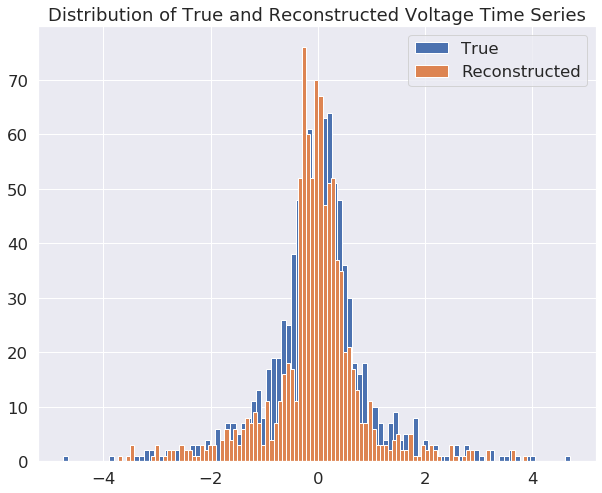

In [426]:
plt.figure(figsize=(10,8))
plt.title("Distribution of True and Reconstructed Voltage Time Series")
plt.hist(signal[:,2], label='True', bins=100)
plt.hist(reconstructed_signal[:,2], label='Reconstructed', bins=100)
plt.legend(loc='best')

In [427]:
normal_reconstruction_error = l1_error(signal, reconstructed_signal)

We can see that our autoencoder reconstructs realy good every channel of our signal and specifically for the voltage metric in which we are interested in, the model seem to confidently recostruct the distribution. 

Lets observe our abnormal datasets

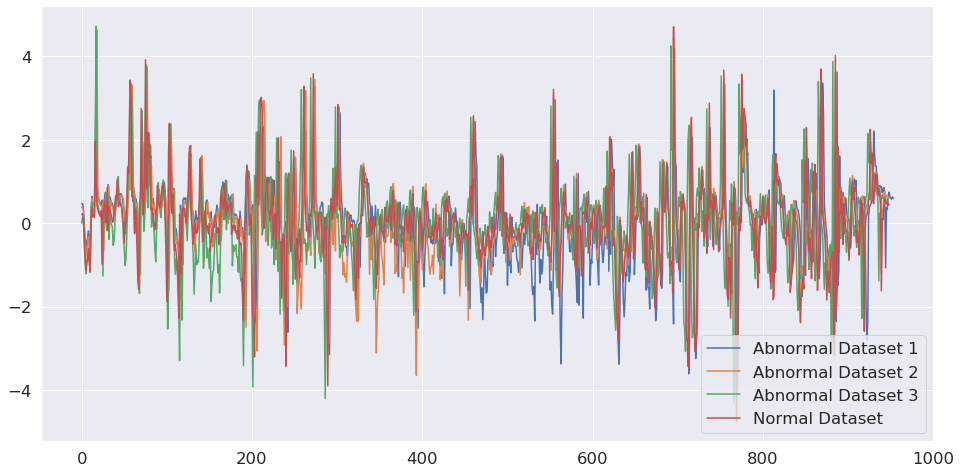

In [428]:
plt.figure(figsize=(16,8))
plt.plot(abnormal_1[:,2].detach().numpy(), label='Abnormal Dataset 1')
plt.plot(abnormal_2[:,2].detach().numpy(), label='Abnormal Dataset 2')
plt.plot(abnormal_3[:,2].detach().numpy(), label='Abnormal Dataset 3')

plt.plot(dataset[:,2].detach().numpy(), label='Normal Dataset')

plt.legend(loc=4)
plt.show()

We already know that in our abnormal dataset there is a voltage outage in one of the subsations which results in a voltage drop around the substation.

### Anomaly Detection

###We will use as threshold the 90% quantile of the rolling average of the reconstruction error to label anomlies.

We have hard set the threshold at 0.25. Another option to set the threshold at 90% quantile to allow as to generally detect outliers.
Also we could a dynamic threshold based on past observations to better detect anomalies in streaming  data

We see that the reconstruction error is noticably higher in the region of the outage so we are able to detect the anomaly. We can also see that the reconstruction error in every other point of the signal is practically the same as the reconstruction error in the normal case.

We are going to implement the above methodology in a function as:

In [337]:
def anomaly_detection(model, dataframe, target_feature, features, title=None):
    if not torch.is_tensor(dataframe[:]):
        dataframe = torch.Tensor(dataframe)


    abnormal_reconstructed_signal = ae(dataframe[:])[0].detach().numpy()
    abnormal_true_signal = dataframe[:].detach().numpy()
    reconstruction_error = pd.DataFrame(l1_error(abnormal_true_signal, abnormal_reconstructed_signal), columns=features)
    #threshold = reconstruction_error[target_feature].rolling(100).mean().quantile(q=0.9)
    threshold = 0.6
    anomalies = reconstruction_error[target_feature].rolling(100).mean() > threshold
    plt.figure(figsize=(8,6))
    if title!=None: plt.title(f"{title} Reconstruction Error")
    plt.plot(reconstruction_error['voltage [V]'].rolling(100).mean())
    plt.figure(figsize=(8,6))
    if title!=None: plt.title(f"{title} Detected Anomalies")
    plt.scatter(range(len(dataframe)), np.where(anomalies, dataframe[:,2].detach().numpy(), None), c='r', label='Outliers')
    plt.plot(dataframe[:,2].detach().numpy(), label='Abnormal Voltage')
    plt.legend(loc='best')


Below we present the experiment conducted at different anomalous datasets as well as normal dataset at the end.

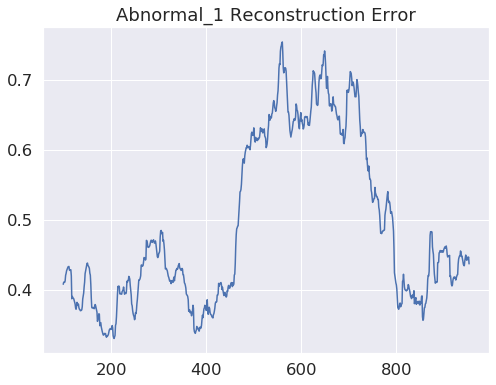

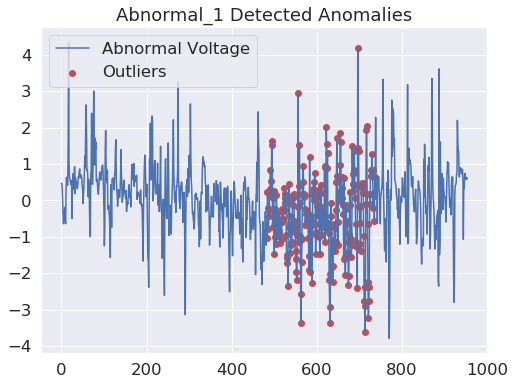

In [338]:
anomaly_detection(ae ,abnormal_1, 'voltage [V]', features ,title="Abnormal_1")

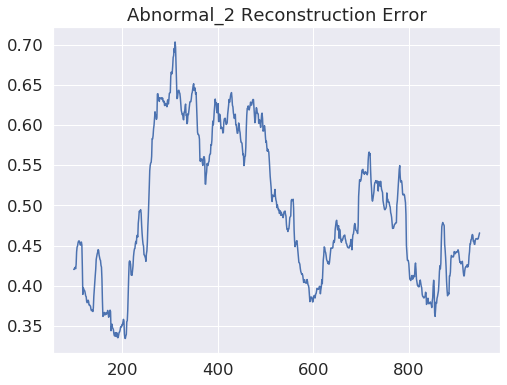

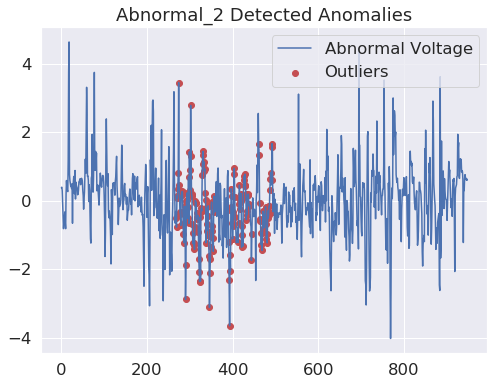

In [339]:
anomaly_detection(ae ,abnormal_2, 'voltage [V]', features, "Abnormal_2")

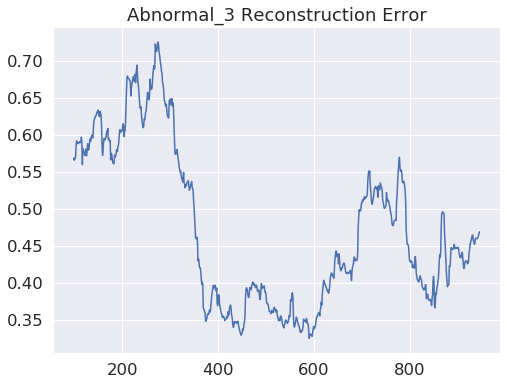

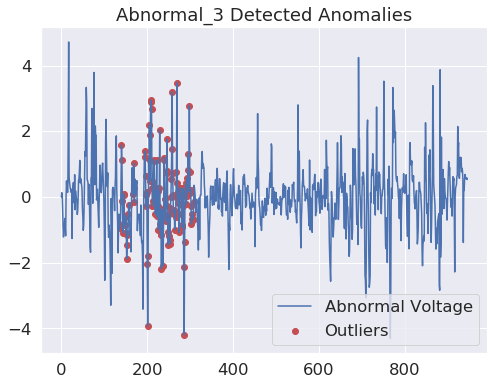

In [340]:
anomaly_detection(ae ,abnormal_3, 'voltage [V]', features, "Abnormal_3")

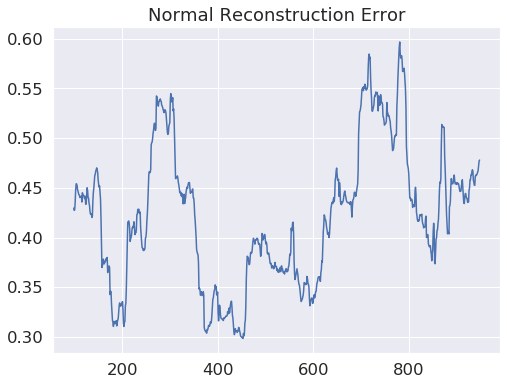

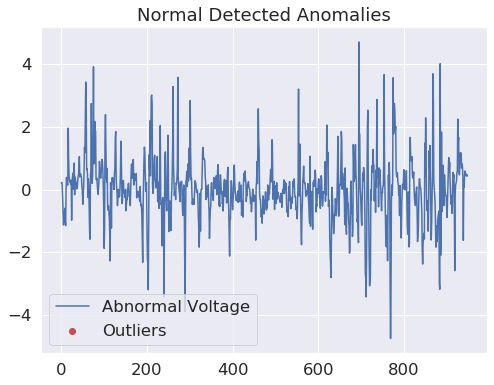

In [341]:
anomaly_detection(ae, dataset, 'voltage [V]', features, "Normal")

## Deployment

###  ONNX

We will use the ONNX to save and deploy our model.
ONNX is an open source ecosystem designed to allow framework interoporability. There are many excellent machine learning libraries in various languages — PyTorch, TensorFlow, MXNet, and Caffe are just a few that have become very popular in recent years, but there are many others as well.
The idea is that you can train a model with one tool stack and then deploy it using another for inference and prediction. To ensure this interoperability you must export your model in the model.onnx format which is serialized representation of the model in a protobuf file. Currently there is native support in ONNX for PyTorch, CNTK, MXNet, and Caffe2 but there are also converters for TensorFlow and CoreML.

ONNX models can be easily deployed using Microsofts ONNX Runtime. ONNX Runtime is a performance-focused complete scoring engine for Open Neural Network Exchange (ONNX) models, with an open extensible architecture to continually address the latest developments in AI and Deep Learning. ONNX Runtime stays up to date with the ONNX standard with complete implementation of all ONNX operators, and supports all ONNX releases (1.2+) with both future and backwards compatibility

In [240]:
import torch.onnx
#we create a dummy input to construct the network
# this AE uses 13 features
dummy_input = torch.randn(1,nb_features)
torch.onnx.export(ae, dummy_input, "autoencoder.onnx", verbose=0)

In [342]:
import onnx

# Load the ONNX model
model = onnx.load("autoencoder.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %input.1[FLOAT, 1x13]
) initializers (
  %1[FLOAT, 1300x13]
  %2[FLOAT, 1300]
  %3[FLOAT, 256x1300]
  %4[FLOAT, 256]
  %5[FLOAT, 64x256]
  %6[FLOAT, 64]
  %7[FLOAT, 32x64]
  %8[FLOAT, 32]
  %9[FLOAT, 16x32]
  %10[FLOAT, 16]
  %11[FLOAT, 4x16]
  %12[FLOAT, 4]
  %13[FLOAT, 16x4]
  %14[FLOAT, 16]
  %15[FLOAT, 32x16]
  %16[FLOAT, 32]
  %17[FLOAT, 64x32]
  %18[FLOAT, 64]
  %19[FLOAT, 256x64]
  %20[FLOAT, 256]
  %21[FLOAT, 1300x256]
  %22[FLOAT, 1300]
  %23[FLOAT, 13x1300]
  %24[FLOAT, 13]
) {
  %25 = Gemm[alpha = 1, beta = 1, transB = 1](%input.1, %1, %2)
  %26 = Relu(%25)
  %27 = Gemm[alpha = 1, beta = 1, transB = 1](%26, %3, %4)
  %28 = Relu(%27)
  %29 = Gemm[alpha = 1, beta = 1, transB = 1](%28, %5, %6)
  %30 = Relu(%29)
  %31 = Gemm[alpha = 1, beta = 1, transB = 1](%30, %7, %8)
  %32 = Relu(%31)
  %33 = Gemm[alpha = 1, beta = 1, transB = 1](%32, %9, %10)
  %34 = Relu(%33)
  %35 = Gemm[alpha = 1, beta = 1, transB = 1](%34, %11, %12)
  %36 = Gemm[alpha = 1, beta

### Onnx Runtime example

In [343]:
import onnx
import numpy as np
import onnxruntime as rt
import time

In [344]:
sess = rt.InferenceSession("autoencoder.onnx")

In [357]:
#we will use for example the first 500 hundred samples
# the onnx model support float32 dtypes
x = normal_data[:500].values.astype("float32")

In [358]:
input_name = sess.get_inputs()[0].name

In [359]:
pred_onnx = sess.run(None, {input_name: x})


In [360]:
pred_onnx[0].shape

(500, 13)

In [387]:
def anomaly_detection_with_onnx(path, dataframe, target_feature, features, title=None):
    sess = rt.InferenceSession(f"{path}")
    #we will use for example the first 500 hundred samples
    # the onnx model support float32 dtypes
    x = dataframe.detach().numpy().astype("float32")
    dataframe = pd.DataFrame(dataframe, columns=features)
    input_name = sess.get_inputs()[0].name
    abnormal_reconstructed_signal, _ = sess.run(None, {input_name: x})
    abnormal_true_signal = x
    reconstruction_error = pd.DataFrame(l1_error(abnormal_true_signal, abnormal_reconstructed_signal), columns=features)
    #threshold = reconstruction_error[target_feature].rolling(100).mean().quantile(q=0.9)
    threshold = 0.35
    anomalies = reconstruction_error[target_feature].rolling(50).mean() > threshold
    plt.figure(figsize=(8,6))
    if title!=None: plt.title(f"{title} Reconstruction Error")
    plt.plot(reconstruction_error[target_feature].rolling(50).mean())
    plt.figure(figsize=(8,6))
    if title!=None: plt.title(f"{title} Detected Anomalies")
    plt.scatter(range(len(dataframe)), np.where(anomalies, dataframe['voltage [V]'], None), c='r', label='Outliers')
    plt.plot(dataframe[target_feature], label='Abnormal Voltage')
    plt.legend(loc='best')

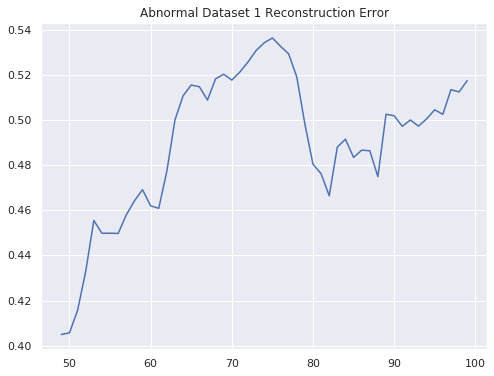

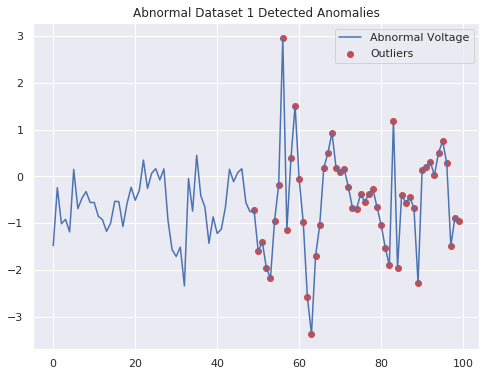

In [394]:
anomaly_detection_with_onnx("autoencoder.onnx", abnormal_1[500:600], 'voltage [V]', features, "Abnormal Dataset 1")